* Import the necessary libraries
* Import BertForSequenceClassification and BertTokenizer from transformers

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from transformers import BertTokenizerFast

Get and load the data from below link -
https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

In [2]:
df = pd.read_csv('/content/fake_job_postings.csv')

In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [5]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
df.drop(columns=['salary_range', 'job_id'], inplace=True)

In [8]:
df.fillna("", inplace=True)

In [9]:
df['text'] = df[['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_education', 'industry', 'function']].agg(' '.join, axis=1)

In [10]:
df.text[0]

"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

In [11]:
columns_to_drop = ['title', 'location', 'department', 'company_profile', 'description',
                   'requirements', 'benefits', 'employment_type', 'required_experience',
                   'required_education', 'industry', 'function']

df.drop(columns=columns_to_drop, inplace=True)

In [12]:
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,1,1,0,"Bill Review Manager US, FL, Fort Worth SpotSo..."


In [13]:
df.columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent',
       'text'],
      dtype='object')

In [14]:
df['text'] = df['text'].apply(str)
df['fraudulent'] = df['fraudulent'].astype(int)

In [15]:
X = df['text'].values
y = df['fraudulent'].values

In [16]:
X = df.drop(columns=['fraudulent'])
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

* Below line of code initializes a tokenizer object for the BERT model.  

In [18]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

* The code utilizes the batch_encode_plus() method of the tokenizer object to tokenize and encode a batch of text inputs for both training and testing data.
* For both training and testing datasets (X_train['text'] and X_test['text'] respectively), the text data is provided as a list, assumed to be contained within the column labeled 'text'.
* The resulting encoded data is returned as PyTorch tensors (return_tensors='pt'), and after encoding, the input sequences (input_ids) along with their corresponding attention masks (attention_masks) and target labels (labels) are moved to the specified device (e.g., GPU) using .to(device), preparing the data for training or evaluation on that device.

In [19]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train['text'].tolist(),  # Assuming 'text' is the column containing your text data
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    X_test['text'].tolist(),  # Assuming 'text' is the column containing your text data
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)

# Move tensors to GPU if available
input_ids_train = encoded_data_train['input_ids'].to(device)
attention_masks_train = encoded_data_train['attention_mask'].to(device)
labels_train = torch.tensor(y_train.tolist(), dtype=torch.long).to(device)

input_ids_test = encoded_data_test['input_ids'].to(device)
attention_masks_test = encoded_data_test['attention_mask'].to(device)
labels_test = torch.tensor(y_test.tolist(), dtype=torch.long).to(device)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


* Initialize a BERT-based sequence classification model using the BertForSequenceClassification class from the Hugging Face transformers library.

* Load a pre-trained BERT model called "bert-base-uncased" and configure it for a binary classification task with two output labels. Additionally, sets parameters output_attentions and output_hidden_states to False, indicating that the model won't output attention weights or hidden states.

In [20]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* Initialize a variable freeze_layers to specify the number of layers to freeze in the BERT model.
* Freezes the parameters of the embedding layer of the BERT model by setting requires_grad to False for all parameters in the embedding layer.
* Iterate through the specified number of layers (freeze_layers) in the BERT encoder and freeze the parameters of each layer by setting requires_grad to False for all parameters in those layers. This prevents these layers from being updated during training, effectively "freezing" them.

In [21]:
freeze_layers = 6
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

for i in range(freeze_layers):
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = False


In [22]:
# Move the model to the GPU
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [23]:
from transformers import AdamW

* Set up DataLoader objects for both training and testing datasets.
* Each DataLoader is initialized with a TensorDataset, which contains input IDs (input_ids_train and input_ids_test), attention masks (attention_masks_train and attention_masks_test), and labels (labels_train and labels_test).

In [24]:
# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Define DataLoader
train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=8)

test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
from tqdm import tqdm
import matplotlib.pyplot as plt

* The below code imports necessary modules including tqdm for progress bars and matplotlib.pyplot for plotting graphs.

* It sets the number of epochs to 3 and initializes empty lists to store training losses and accuracies.

In [26]:
from tqdm import tqdm
import matplotlib.pyplot as plt

epochs = 3
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Wrap the training dataloader with tqdm
    for batch in tqdm(train_dataloader, total=len(train_dataloader)):
        batch_input_ids, batch_attention_masks, batch_labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == batch_labels.to(device)).item()
        total_predictions += len(preds)

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Compute accuracy for the epoch
    epoch_accuracy = correct_predictions / total_predictions
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {epoch_accuracy}')

100%|██████████| 1788/1788 [15:46<00:00,  1.89it/s]


Epoch 1/3, Average Training Loss: 0.10562770779885798, Training Accuracy: 0.9674916107382551


100%|██████████| 1788/1788 [15:55<00:00,  1.87it/s]


Epoch 2/3, Average Training Loss: 0.044450552964343956, Training Accuracy: 0.9867869127516778


100%|██████████| 1788/1788 [15:52<00:00,  1.88it/s]

Epoch 3/3, Average Training Loss: 0.02493552630042072, Training Accuracy: 0.9926593959731543


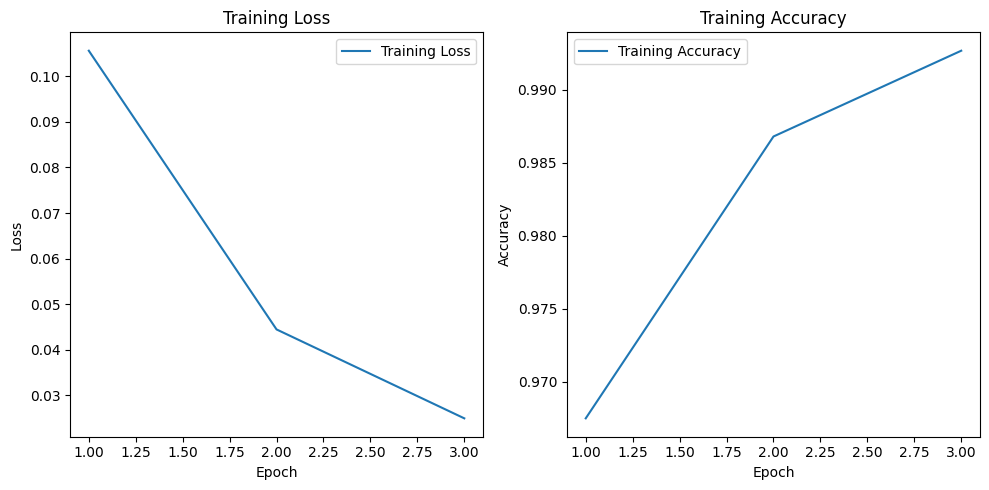

In [27]:
# Plot training loss and accuracy
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1),train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1),train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

* The below code imports necessary modules including tqdm for progress bars, DataLoader and TensorDataset from torch.utils.data for handling datasets, torch for tensor operations, and matplotlib.pyplot for plotting graphs.

In [30]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import torch
import matplotlib.pyplot as plt

batch_size = 8  # Adjust batch size as needed
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()

total_correct = 0
total_loss = 0
num_samples = 0
test_losses = []

with torch.no_grad(), tqdm(total=len(test_dataloader)) as pbar:
    for batch in test_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = batch
        outputs = model(input_ids=batch_input_ids.to(device), attention_mask=batch_attention_masks.to(device), labels=batch_labels.to(device))
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        total_correct += torch.sum(preds == batch_labels.to(device)).item()
        loss = outputs.loss
        total_loss += loss.item()
        test_losses.append(loss.item())
        num_samples += batch_labels.size(0)
        pbar.update(1)

# Calculate accuracy and test loss
accuracy = total_correct / num_samples
test_loss = total_loss / len(test_dataloader)

100%|██████████| 447/447 [02:02<00:00,  3.65it/s]


In [34]:
print(f'Test Accuracy: {accuracy * 100:.4f}%')
print(f'Test Loss: {test_loss:.4f}')


Test Accuracy: 97.0917%
Test Loss: 0.0936
